In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.rcParams = plt.rcParamsOrig

# Bayesian A/B Testing

The following code is adapted from [Probabilistic Programming and Bayesian Methods for Hackers](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter4_TheGreatestTheoremNeverTold/Ch4_LawOfLargeNumbers_PyMC3.ipynb).

In [2]:
def posterior_conversion_rate(converted, bounced, samples=20000):
    N = converted + bounced
    with pm.Model() as model:
        conversion_rate = pm.Uniform("conversion_rate", 0, 1)
        observations = pm.Binomial("obs", N, conversion_rate, observed=converted)
        
        trace = pm.sample(samples, tune=2000, step=pm.Metropolis())
    
    burned_trace = trace[int(samples/4):]
    return burned_trace["conversion_rate"]

Let's take some samples!

In [3]:
a = posterior_conversion_rate(313, 1027 - 313)
b = posterior_conversion_rate(308, 1032 - 308)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '1578' (I am process '2339')
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [conversion_rate]


Sampling 4 chains for 2_000 tune and 20_000 draw iterations (8_000 + 80_000 draws total) took 14 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [conversion_rate]


Sampling 4 chains for 2_000 tune and 20_000 draw iterations (8_000 + 80_000 draws total) took 14 seconds.
The number of effective samples is smaller than 25% for some parameters.


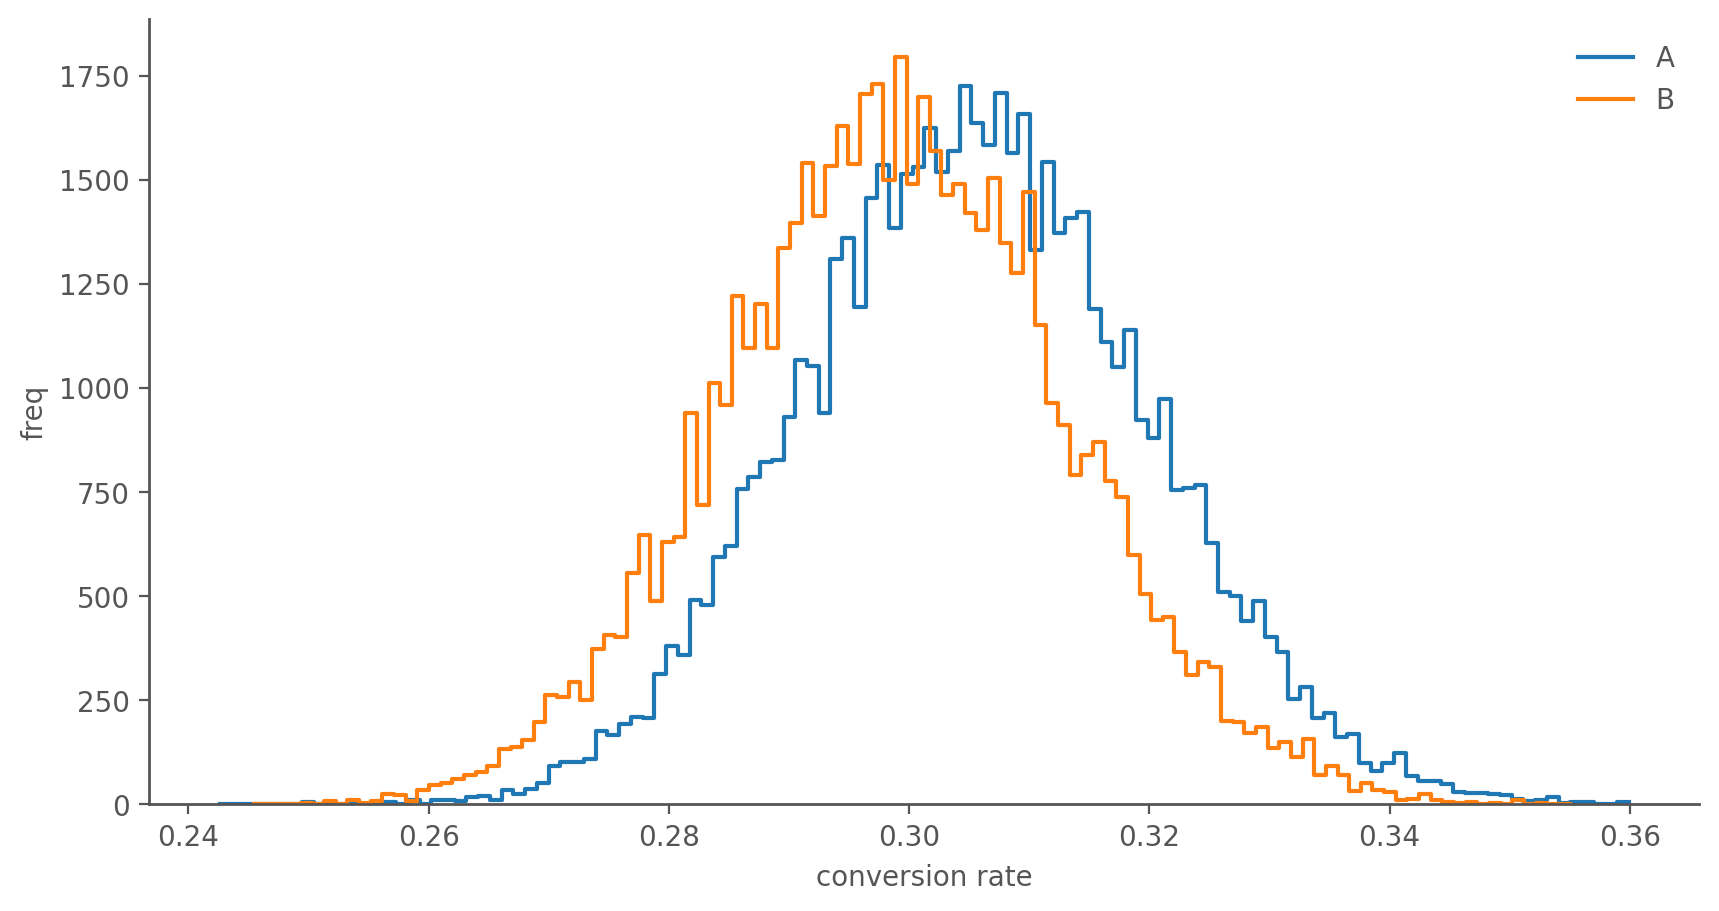

In [4]:
ax = plt.gca()
sns.histplot(x=a, element='step', fill=False, label='A', ax=ax)
sns.histplot(x=b, element='step', fill=False, label='B', ax=ax)
plt.xlabel('conversion rate')
plt.ylabel('freq')
plt.legend();

Let's do it ourselves so we can actually modify the results as we want. In this case, we reframe the problem from $p(a > b)$ to $p(a-b > 0)$.

In [5]:
converted_a = 313
converted_b = 308
N_a = 1027
N_b = 1032
bounced_a = N_a - converted_a
bounced_b = N_b - converted_b

with pm.Model() as model:
    p_a = pm.Uniform("p_a", 0, 1)
    p_b = pm.Uniform("p_b", 0, 1)
    y_a = pm.Binomial("y_a", N_a, p_a, observed=converted_a)
    y_b = pm.Binomial("y_b", N_b, p_b, observed=converted_b)
    diff = pm.Deterministic('p_a-p_b', p_a - p_b)

    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_b, p_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


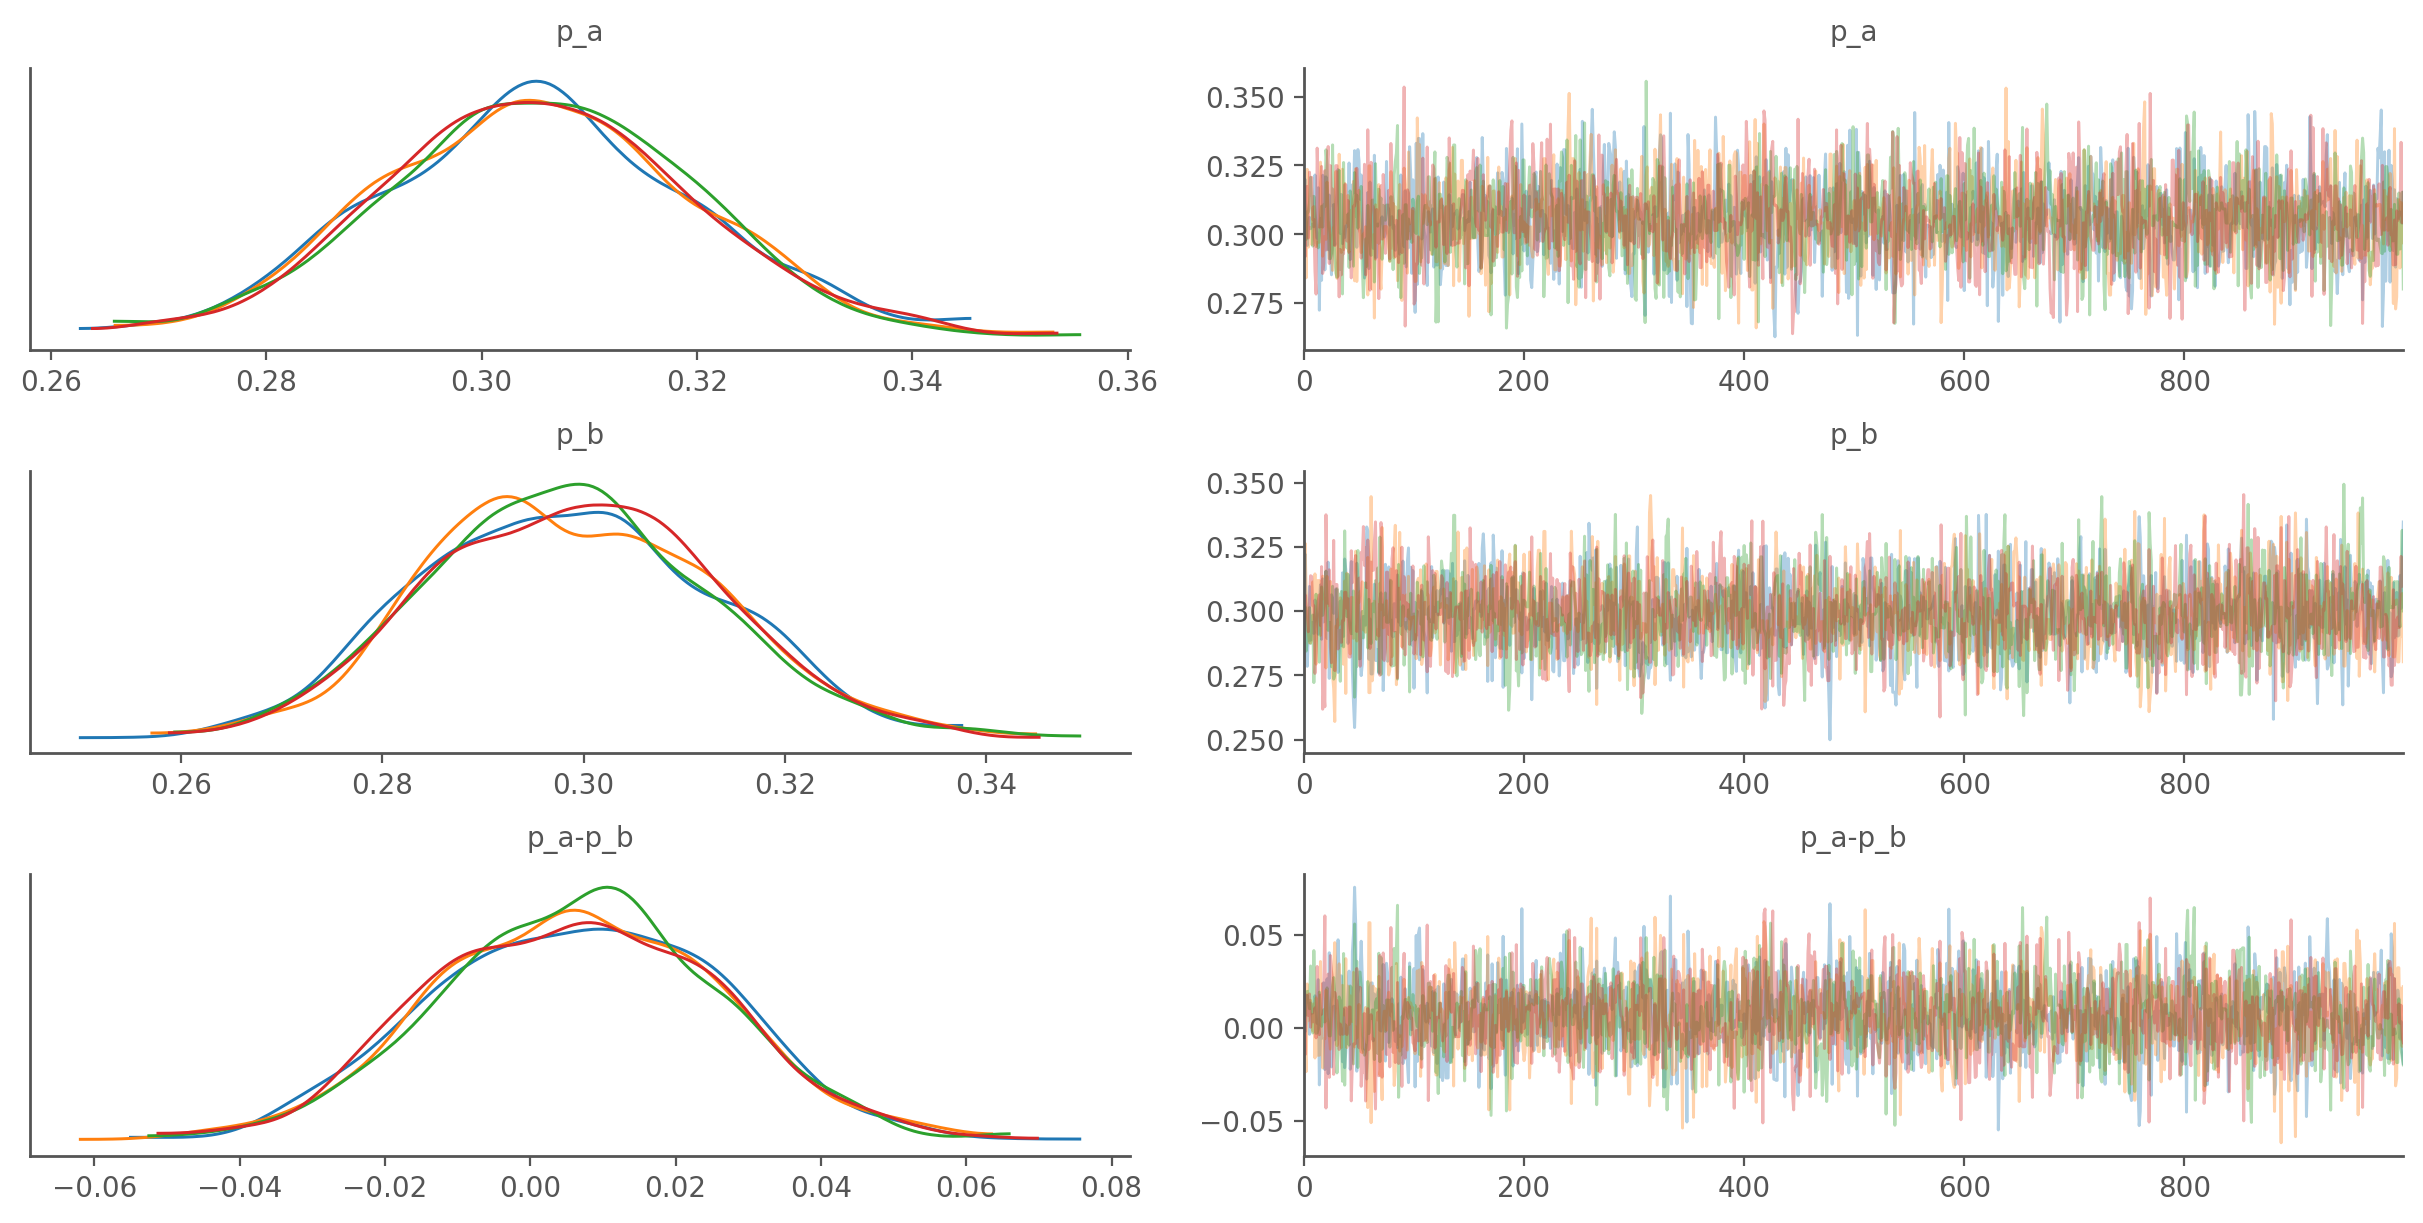

In [6]:
with model:
    az.plot_trace(trace)

In [7]:
from IPython.display import display

with model:
    display(az.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p_a,0.305,0.014,0.280,0.333,0.0,0.0,3727.0,3727.0,3721.0,2675.0,1.0
p_b,0.299,0.014,0.274,0.327,0.0,0.0,3514.0,3507.0,3507.0,2961.0,1.0
p_a-p_b,0.007,0.020,-0.030,0.043,0.0,0.0,3690.0,2256.0,3702.0,2913.0,1.0


The following figure shows that the mean of $CTP_B$ is larger thatn $CTP_A$, but is it always the case that $CTP_B > CTP_A$?

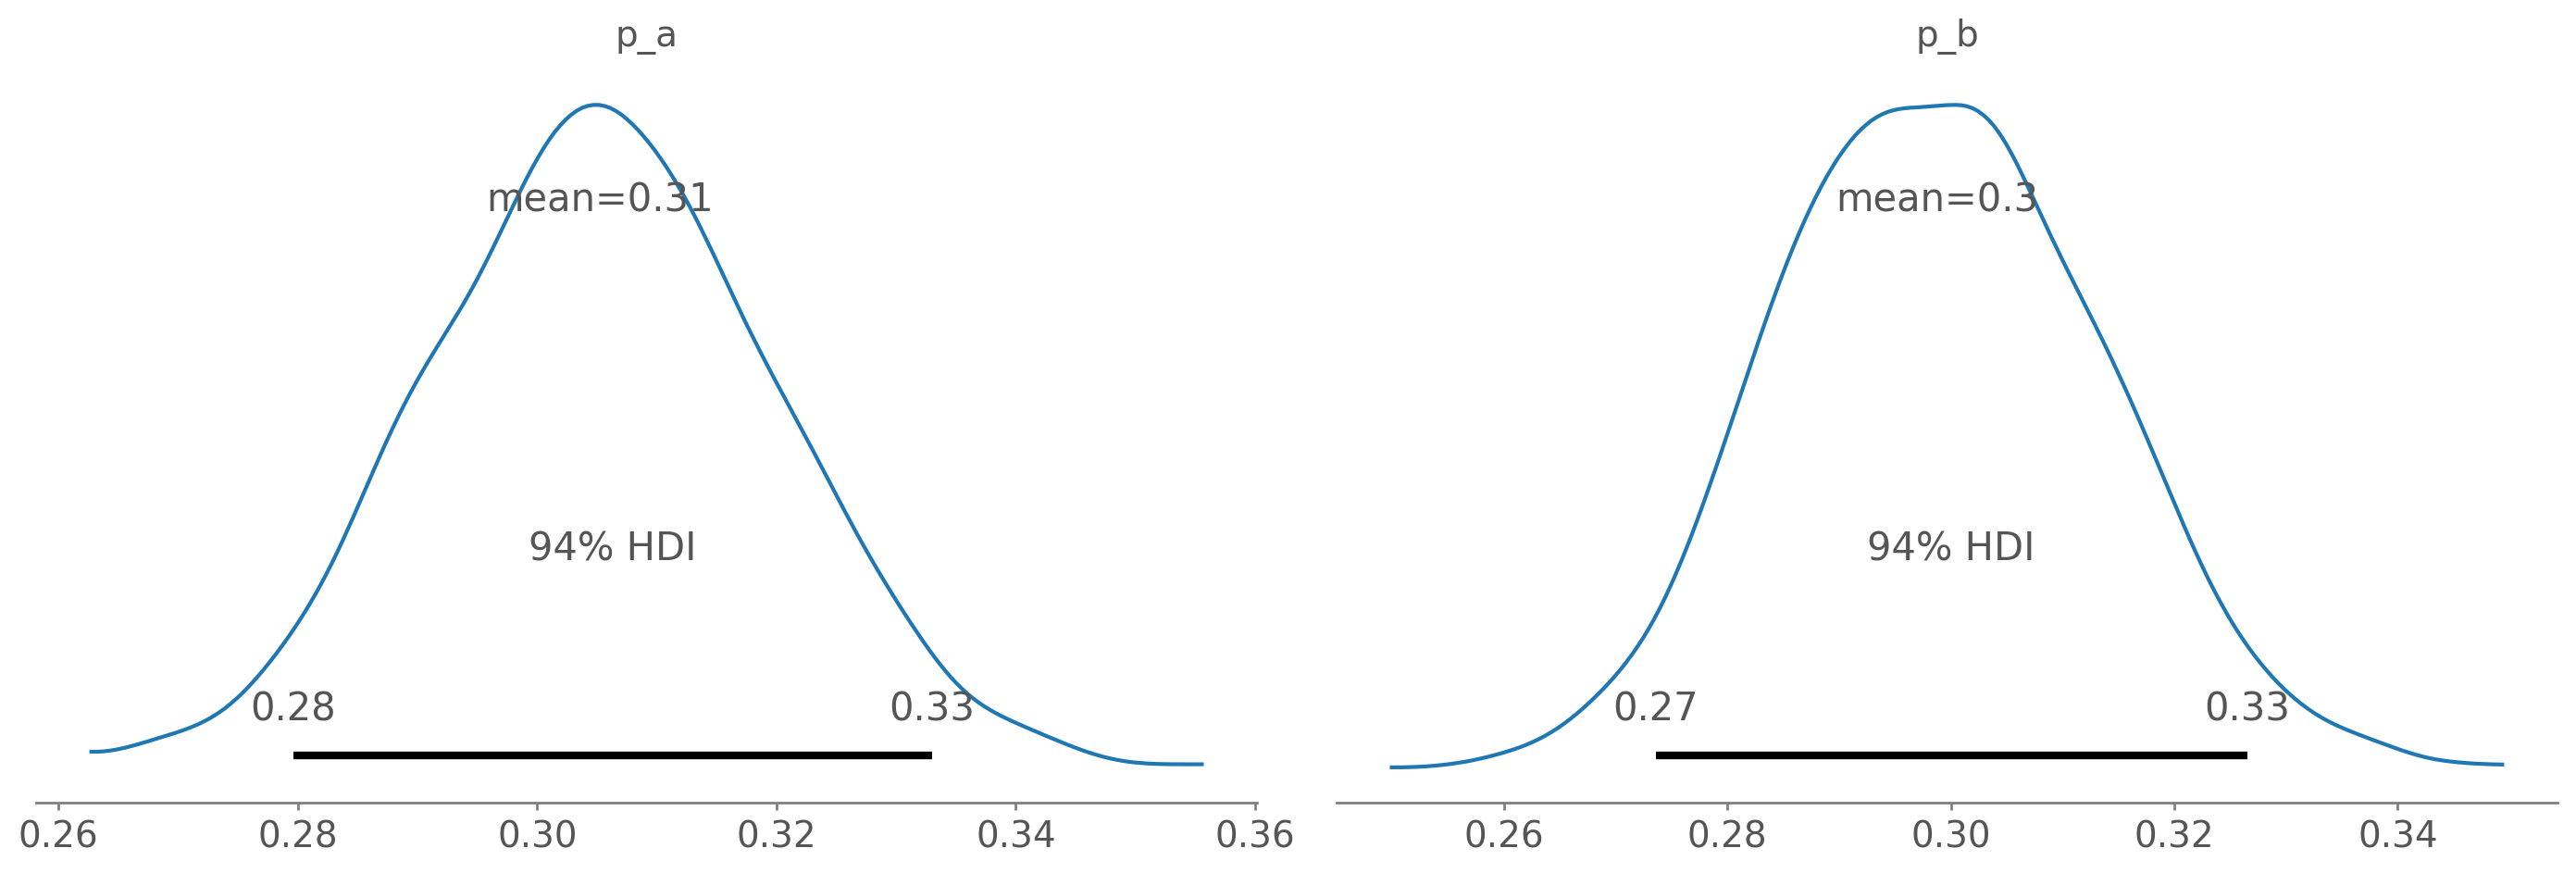

In [8]:
with model:
    az.plot_posterior(trace, var_names=['p_a', 'p_b'])

It turns out, we can just subtract both CTPs! The interpretation of the following figure should be quite intuitive: the probability of seeing option A gets more conversion than option B is only 0.0568 which means it is more likely to see the opposite!

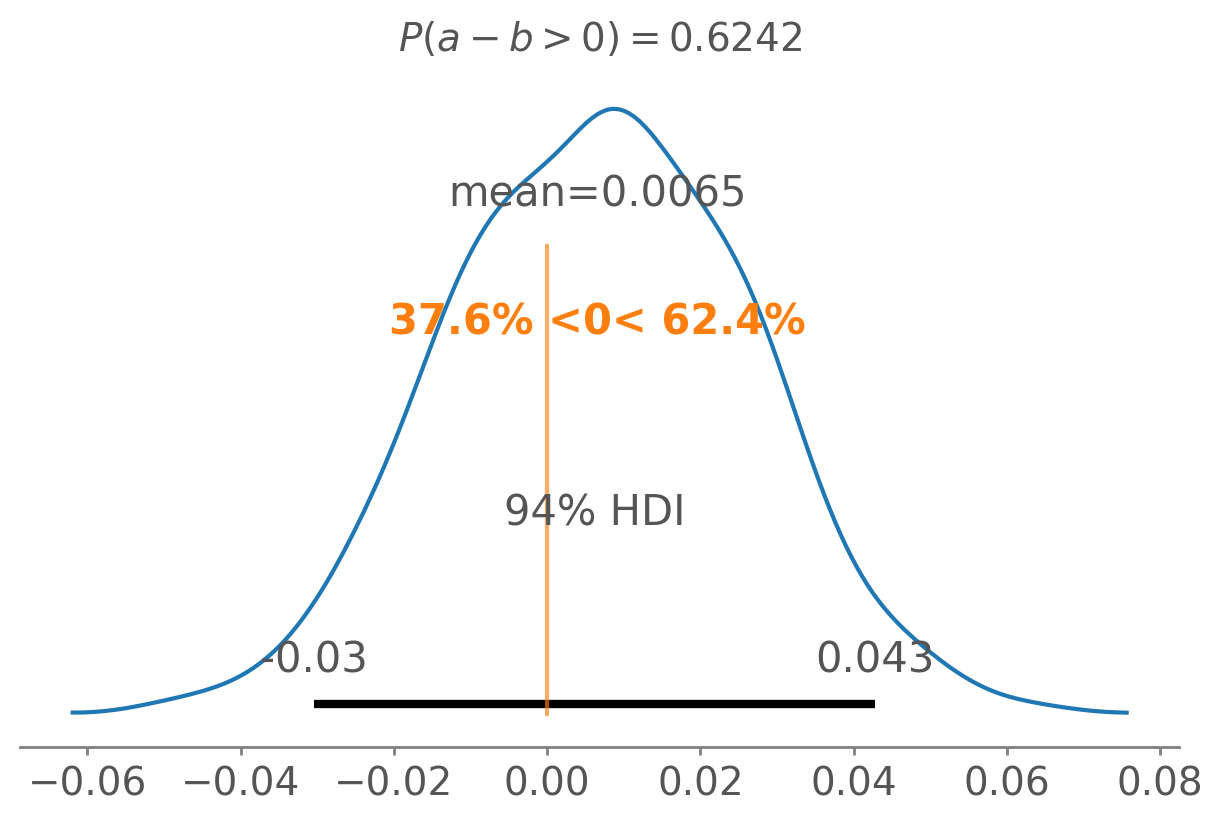

In [9]:
with model:
    az.plot_posterior(
        trace,
        var_names=['p_a-p_b'],
        ref_val=0
    )
    plt.title('$P(a-b > 0) = {:.4f}$'.format(
        (trace['p_a-p_b'] > 0).mean()
    ))

# Bayesian Search Ranking

First, we will generate a random dataset.

In [10]:
np.random.seed(42)

no_prop = 10
all_ratings = pd.DataFrame()

for i in range(no_prop):
    no_ratings = max(0, int(40*np.random.standard_t(3)+50))
    ratings = pd.DataFrame({
        'property_id': [i] * no_ratings,
        'rating': np.round(10*np.random.beta(7, 2, size=no_ratings), 0)
    })
    all_ratings = pd.concat([
        all_ratings,
        ratings
    ])

Now, let's report the summary statistics. Also, order the properties based on their average rating.

In [11]:
agg_review = all_ratings.groupby('property_id').agg({
    'rating': ['mean', 'std', 'sum', 'count']
}).rating.reset_index()

(
    agg_review[['property_id','mean','std','count']]
    .sort_values('mean', ascending=False)
    .set_index('property_id')
    .style
    .format({
        'mean': '{:.2f}',
        'std': '{:.2f}'
    })
)

,mean,std,count
property_id,,,
4,8.25,1.24,16
8,8.11,0.98,36
5,8.03,1.21,29
1,7.87,1.34,91
3,7.84,1.12,51
6,7.84,1.36,114
7,7.70,1.34,20
9,7.50,1.35,10
0,7.46,1.42,74


We can dig deeper in this problem. Let's take two example properties: prop 3 and 6. Our "usual" solution will look like the following figure.

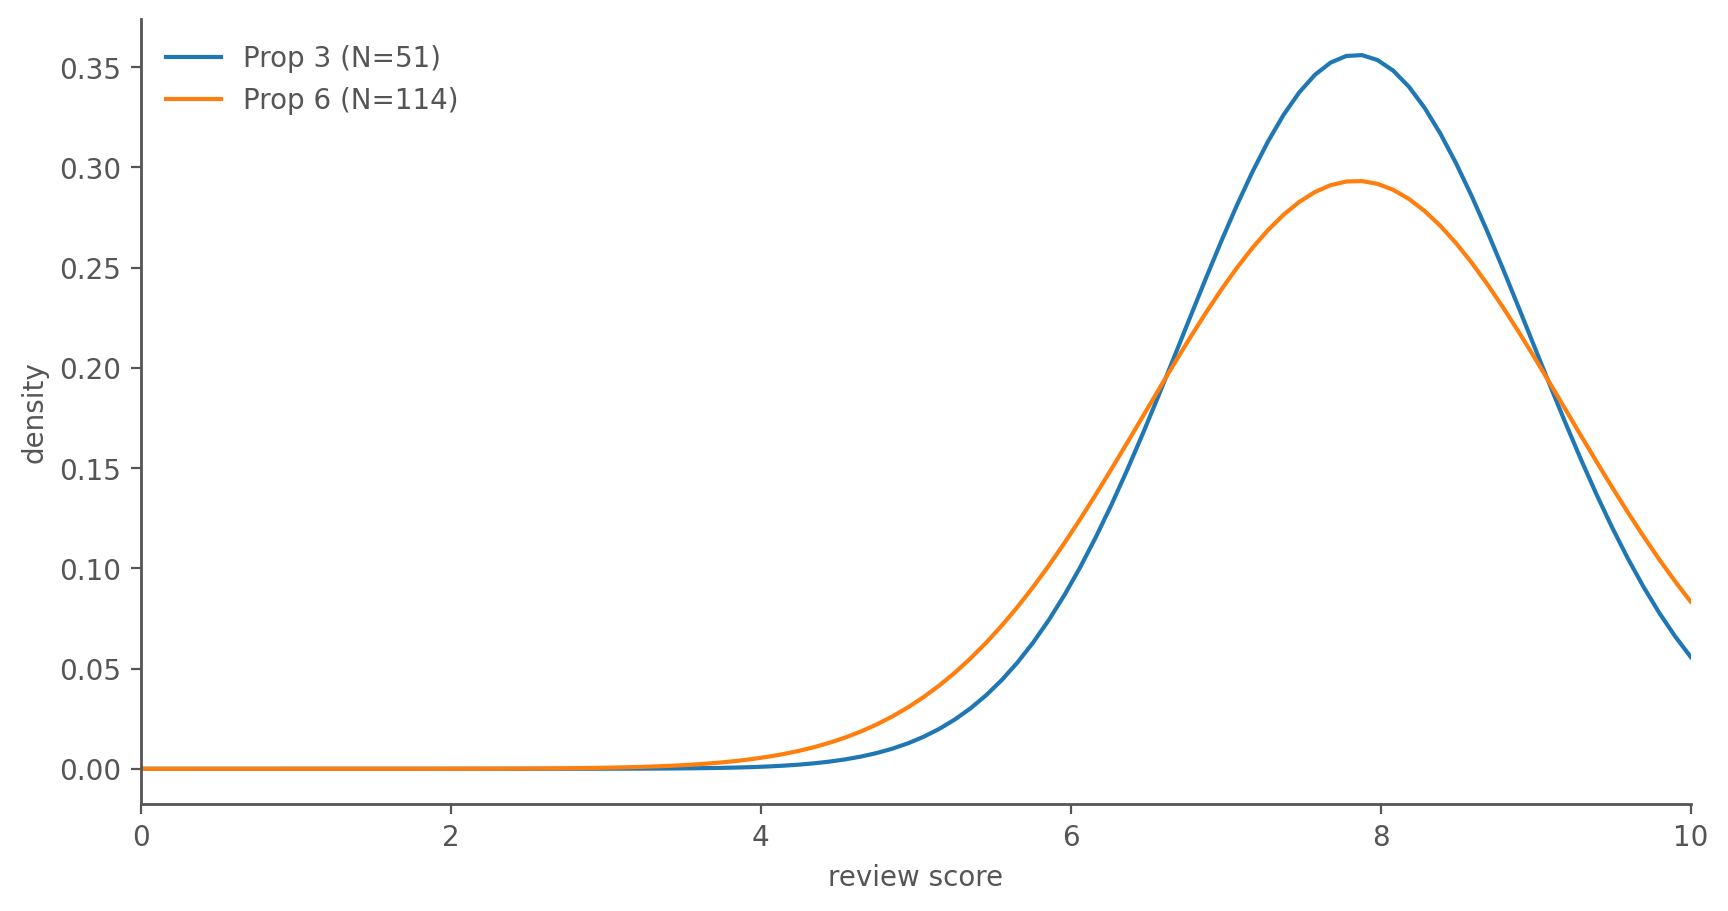

In [12]:
from scipy.stats import norm

def draw_norm(property_id, ax):
    prop = all_ratings.query('property_id == {}'.format(property_id))
    no_ratings = len(prop)

    x = np.linspace(0, 1, 100)
    ax.plot(
        x*10,
        norm.pdf(x*10, prop.rating.mean(), prop.rating.std()),
        label='Prop {} (N={})'.format(property_id, len(prop))
    )

ax = plt.gca()
draw_norm(3, ax)
draw_norm(6, ax)
plt.xlim([0,10])
plt.xlabel('review score')
plt.ylabel('density')
plt.legend();

You can see in the previous figure that we don't really take N into account. We should be more certain when we see larger number of samples. What can we do to incorporate this? Use beta distribution!

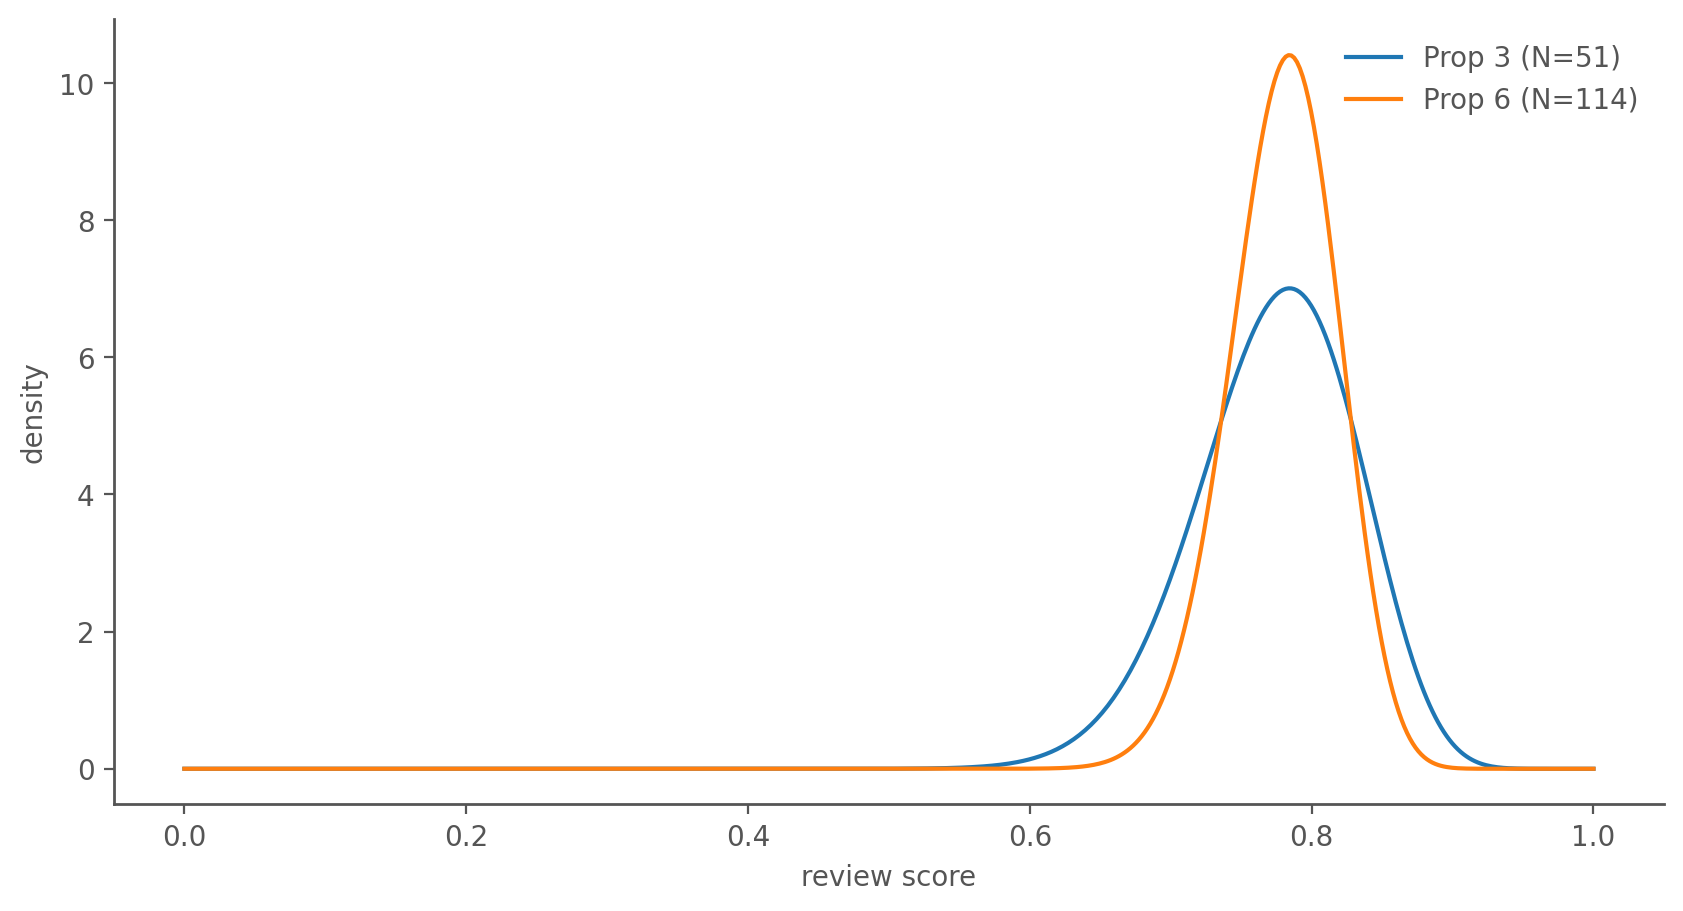

In [13]:
from scipy.stats import beta

def draw_beta(property_id, ax):
    prop = all_ratings.query('property_id == {}'.format(property_id))
    no_ratings = len(prop)

    x = np.linspace(0, 1, 500)
    ax.plot(
        x,
        beta.pdf(x, 1+prop.rating.sum()/10, 1+no_ratings-prop.rating.sum()/10),
        label='Prop {} (N={})'.format(property_id, len(prop))
    )
    
ax = plt.gca()
draw_beta(3, ax)
draw_beta(6, ax)
plt.xlabel('review score')
plt.ylabel('density')
plt.legend();

Prop 6 which has more ratings is more certain about the true review score! Yay! However, as we are recommending our properties to our customers, and we consider ourselves customer-centric, we should be more cautious, no?

Therefore, we can use the *95% least plausible value*.

> Why is sorting based on this quantity a good idea? By ordering by the 95% least plausible value, we are being the most conservative with what we think is best. [(Davidson-Pilon, 2015)](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter4_TheGreatestTheoremNeverTold/Ch4_LawOfLargeNumbers_PyMC3.ipynb)

## Exploratory Code

We can use a similar codebase to the one we've written before!

In [14]:
def posterior_score(N, sum_of_ratings, samples=20000):
    gap_from_perfect_ratings = N - sum_of_ratings
    with pm.Model() as model:
        true_score = pm.Uniform("true_score", 0, 1)
        observations = pm.Binomial("obs", N, true_score, observed=sum_of_ratings)
        
        trace = pm.sample(samples, tune=1500)
    
    burned_trace = trace[int(samples/4):]
    return burned_trace["true_score"]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_score]


Sampling 4 chains for 1_500 tune and 5_000 draw iterations (6_000 + 20_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.8881339874474649, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_score]


Sampling 4 chains for 1_500 tune and 5_000 draw iterations (6_000 + 20_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.8884290244884598, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_score]


Sampling 4 chains for 1_500 tune and 5_000 draw iterations (6_000 + 20_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.8877009025457643, but should be close to 0.8. Try to increase the number of tuning steps.


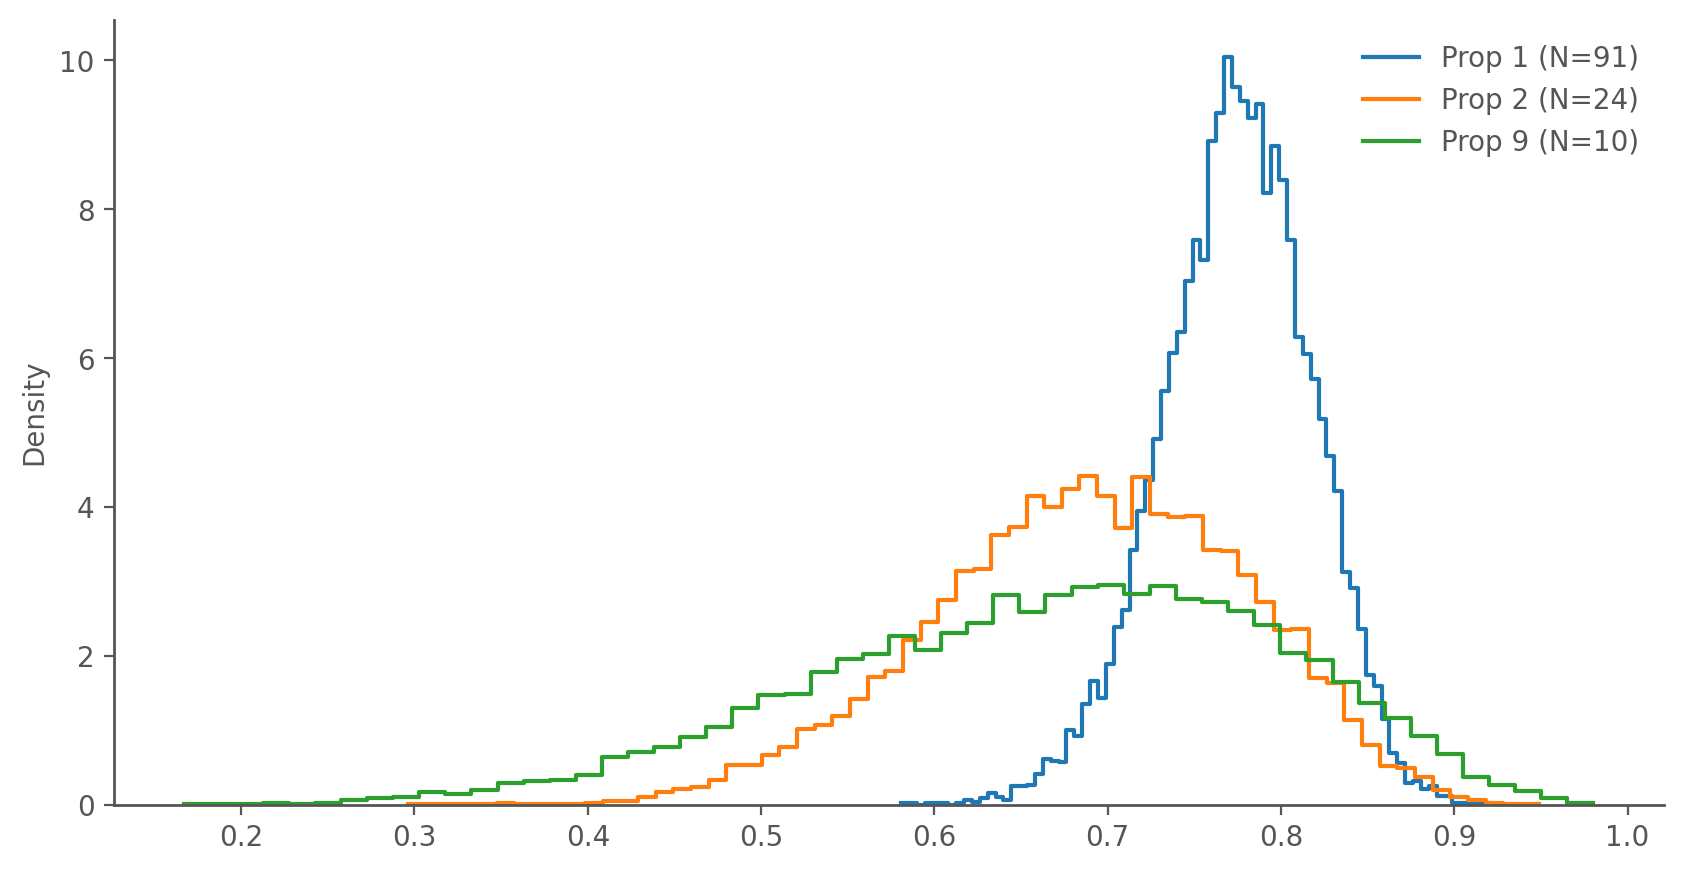

In [15]:
ax = plt.gca()
for i, row in agg_review.filter(regex='(1|2|9)', axis=0).iterrows():
    true_score = posterior_score(row['count'], row['sum']/10, 5000)
    sns.histplot(
        true_score,
        label=f"Prop {row['property_id']:.0f} (N={row['count']:.0f})",
        stat='density',
        element='step',
        fill=False,
        ax=ax
    )
plt.legend();

## Production-friendly Code

The following code is from the analytical solution, i.e. deriving the posterior distribution and using the normal/Gaussian distribution approximation to the beta distribution.

\begin{align*}
X &\sim Beta(a, b) \\
E[X] &= \frac{a}{a + b} \\
SD[X] &= \sqrt{\frac{ab}{(a+b)^2(a + b + 1)}}
\end{align*}

In [16]:
def lower_bound(a, b):
    mean = a / (a + b)
    stdev = 1.65 * np.sqrt((a*b)/((a+b)**2 * (a + b + 1)))
    return mean, stdev

In [17]:
agg_review['mle'] = agg_review['mean']
posterior_mean, std_err = lower_bound(
    1 + agg_review['sum'] / 10,
    1 + agg_review['count'] - agg_review['sum'] / 10
)
agg_review['lower'] = pd.Series(posterior_mean) - pd.Series(std_err)
agg_review['posterior_mean'] = posterior_mean
agg_review['std_err'] = std_err

In [18]:
agg_review['a'] = agg_review['sum'] / 10
agg_review['b'] = agg_review['count'] - agg_review['a']

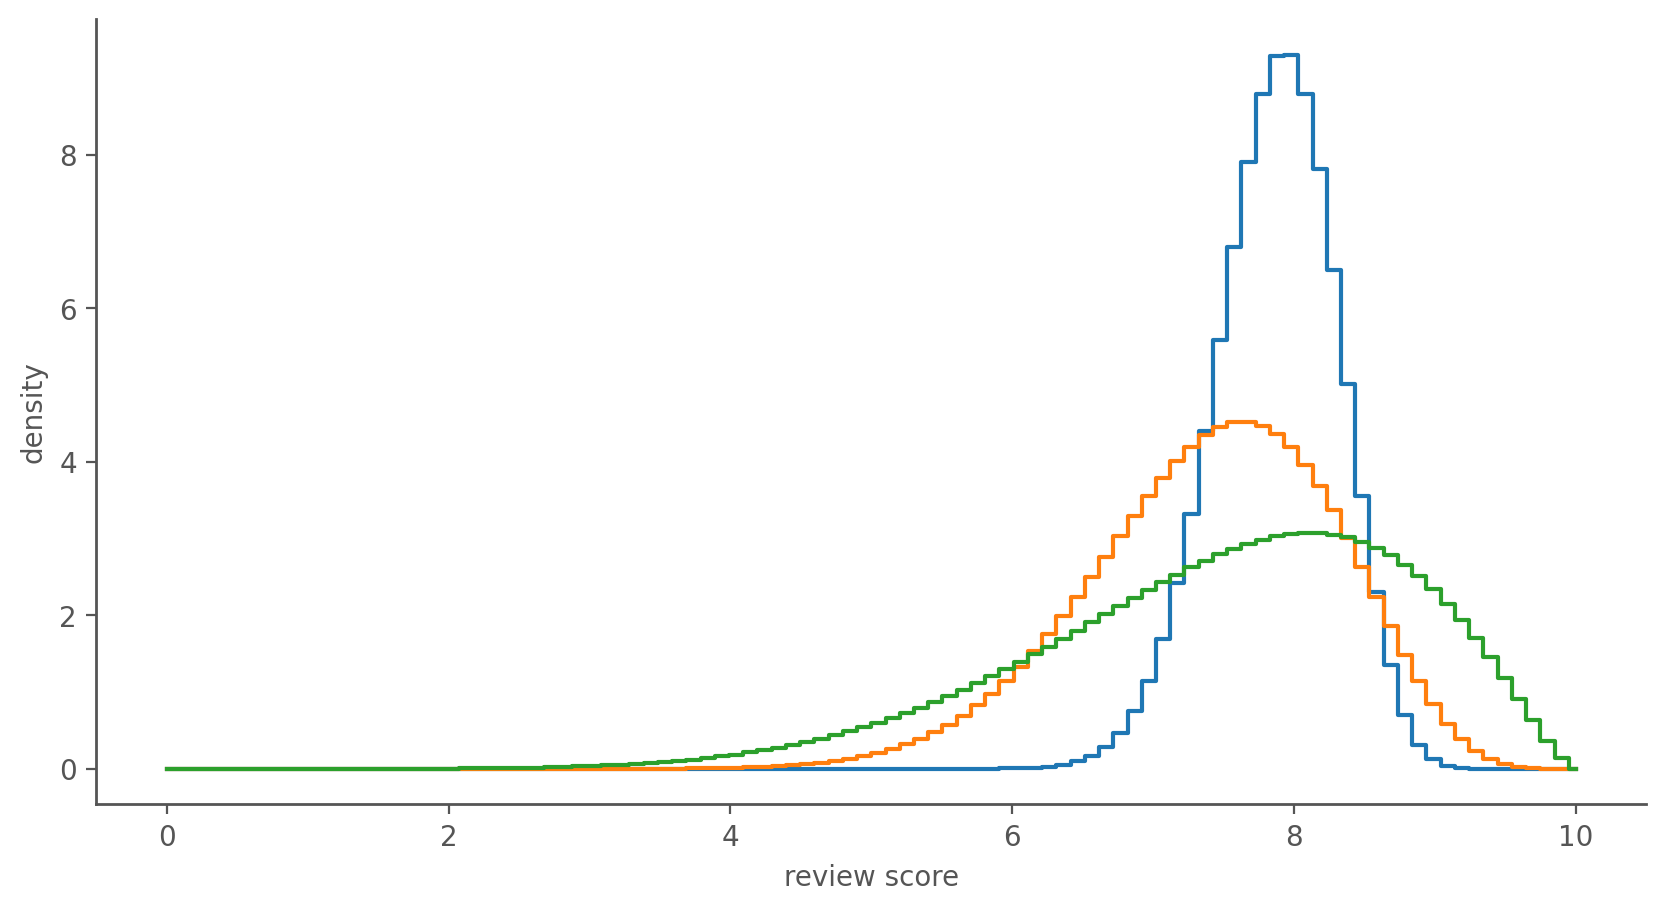

In [19]:
from scipy.stats import beta

x = np.linspace(0, 1, 100)
for pid in [1, 2, 9]:
    plt.step(x*10, beta.pdf(x, agg_review['a'][pid], agg_review['b'][pid]), where='mid')
plt.xlabel('review score')
plt.ylabel('density')
plt.savefig('review-hist.png', bbox_inches='tight', transparent=True, dpi=200)

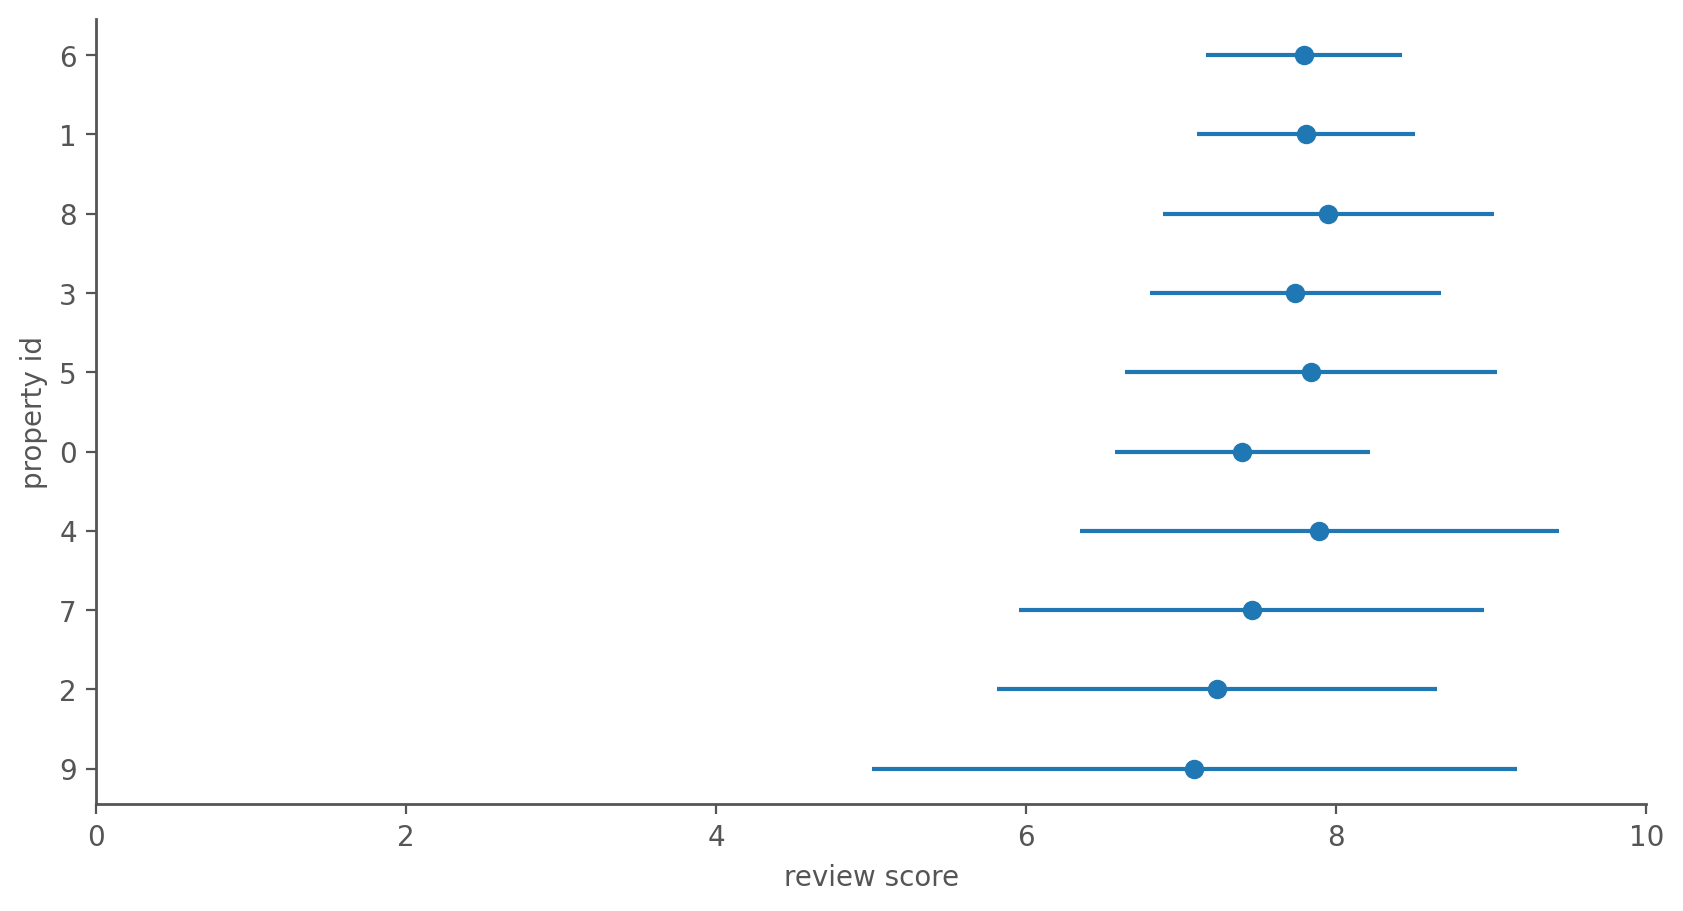

In [20]:
order = np.argsort(agg_review['lower']).values
ax = plt.gca()
ax.errorbar(
    x=agg_review.iloc[order]['posterior_mean']*10,
    y=np.arange(len(order)),
    xerr=agg_review.iloc[order]['std_err']*10,
    capsize=0,
    fmt='o'
)
plt.xlim(0, 10)
plt.yticks(range(len(agg_review)), agg_review.iloc[order]['property_id'])
plt.xlabel('review score')
plt.ylabel('property id')
plt.savefig('ranking.png', bbox_inches='tight', transparent=True, dpi=200)

# Exercise 1

> As I mentioned in my recent post, my paper has been accepted for poster presentation at Bayesian Optimisation Workshop at NIPS 2016. List of accepted paper has also appeared on the workshop’s website. There are 26 papers accepted in total. From the submission, my paper was given ID 12 and appears 9th on the list.
> Since the list of accepted papers is not ordered in alphabetical order (title nor author), I assume the list is ordered by the submission ID. I also assume that the submission ID is given by the order of submission. The question is “given the above information, estimate how many papers were submitted to BayesOpt 2016?”

*Hint: Binomial distribution is your friend.*

# Exercise 2

With the `mpg` dataset, what is the effect of adding more weights to fuel consumption?

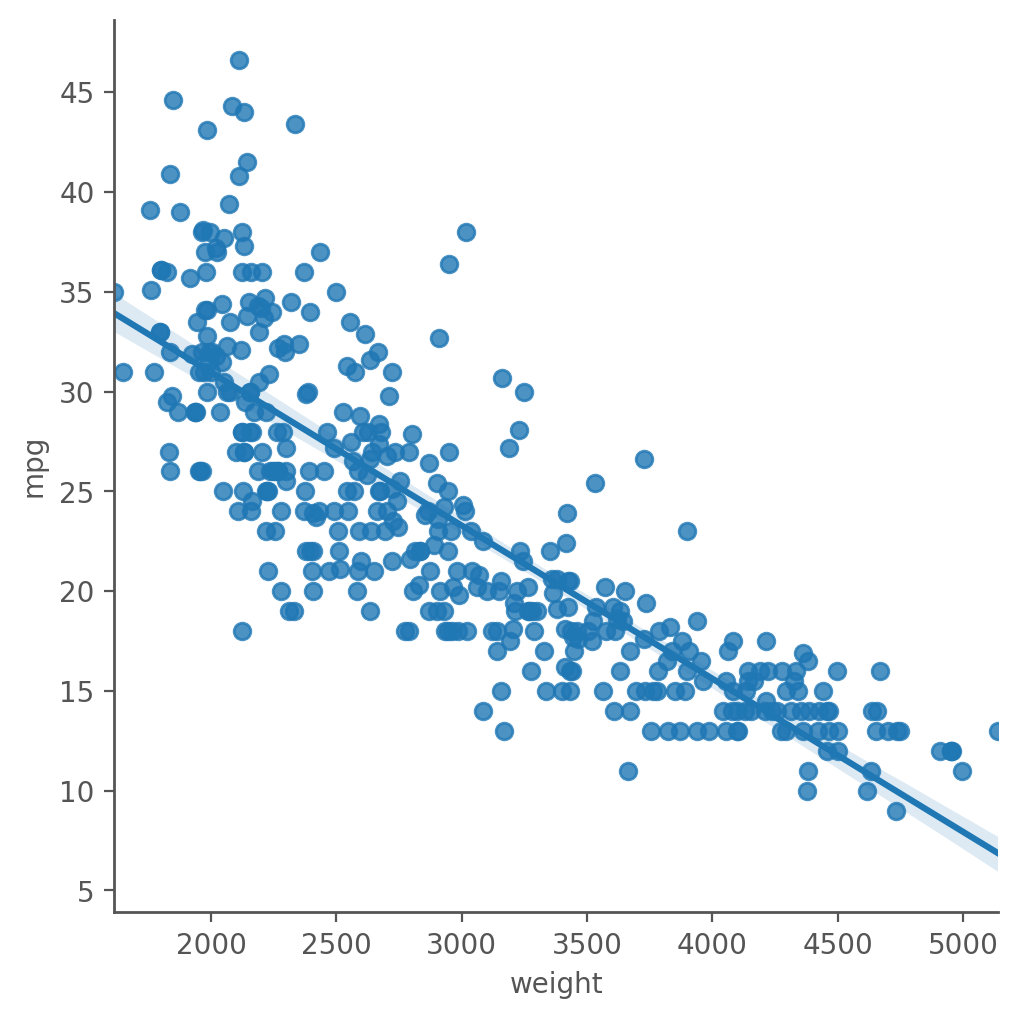

In [41]:
df = sns.load_dataset('mpg')
sns.lmplot(
    x='weight',
    y='mpg',
    data=df
);